In [5]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter
import os
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.utils import plot_model

In [4]:
## Defining batch specfications
batch_size = 100
img_height = 250
img_width = 250

In [5]:
# Path to the training data directory using raw string
data_dir = r'C:\Users\jisan\Downloads\Fire Data-20240531T160026Z-001\Fire Data\Data 3\Train'

# Loading training set
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)


Found 1800 files belonging to 2 classes.


In [6]:
# Path to the validation data directory using raw string
validation_data_dir = r'C:\Users\jisan\Downloads\Fire Data-20240531T160026Z-001\Fire Data\Data 1-2 val'

# Loading validation dataset
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    validation_data_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 1219 files belonging to 2 classes.


In [7]:
# Path to the testing data directory using raw string
testing_data_dir = r'C:\Users\jisan\Downloads\Fire Data-20240531T160026Z-001\Fire Data\Data 3\Test'

# Loading testing dataset
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    testing_data_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 200 files belonging to 2 classes.


In [8]:
testing_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
class_names = training_data.class_names
class_names

['Fire', 'Neutral']

In [10]:
# ImageDataGenerator instances with additional augmentations
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [11]:
# Path to directories using raw strings
train_dir = r'C:\Users\jisan\Downloads\Fire Data-20240531T160026Z-001\Fire Data\Data 3\Train'
validation_dir = r'C:\Users\jisan\Downloads\Fire Data-20240531T160026Z-001\Fire Data\Data 1-2 val'
test_dir = r'C:\Users\jisan\Downloads\Fire Data-20240531T160026Z-001\Fire Data\Data 3\Test'

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'
)

# Validation generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'
)

Found 1800 images belonging to 2 classes.
Found 1219 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [13]:
## Model definition
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = ResNet50(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False)

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Build final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 250, 250,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 125, 125,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 125, 125,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 125, 125,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 127, 127,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 63, 63,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 63, 63,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 63, 63,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 63, 63,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 63, 63,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 63, 63,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 63, 63,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 63, 63,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 63, 63,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 63, 63,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 63, 63,    │      1,024 │ conv2_block1_3_c

 Total params: 25,696,138 (98.02 MB)

 Trainable params: 2,108,426 (8.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
!pip install pydot
# !brew install graphviz
# !sudo apt-get install graphviz

In [16]:

# Visualize the model
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

In [18]:
history = model.fit(train_generator, epochs=50, validation_data=validation_generator)

Epoch 1/50


C:\Users\jisan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 345s 17s/step - accuracy: 0.5166 - loss: 1.5508 - val_accuracy: 0.7506 - val_loss: 0.5941
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 228s 12s/step - accuracy: 0.5861 - loss: 0.6771 - val_accuracy: 0.7605 - val_loss: 0.5527
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 248s 13s/step - accuracy: 0.6692 - loss: 0.6024 - val_accuracy: 0.6842 - val_loss: 0.6472
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 227s 12s/step - accuracy: 0.7542 - loss: 0.5453 - val_accuracy: 0.6349 - val_loss: 0.7178
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 212s 11s/step - accuracy: 0.7407 - loss: 0.5404 - val_accuracy: 0.6957 - val_loss: 0.6428
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 222s 12s/step - accuracy: 0.7411 - loss: 0.5250 - val_accuracy: 0.6473 - val_loss: 0.7183
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 227s 12s/step - accuracy: 0.7360 - loss: 0.5244 - val_accuracy: 0.7030 - val_loss: 0.6434
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 215s 12s/step - accuracy: 0.7542 - loss: 0.5059 - val_accuracy: 0.6210 - val_

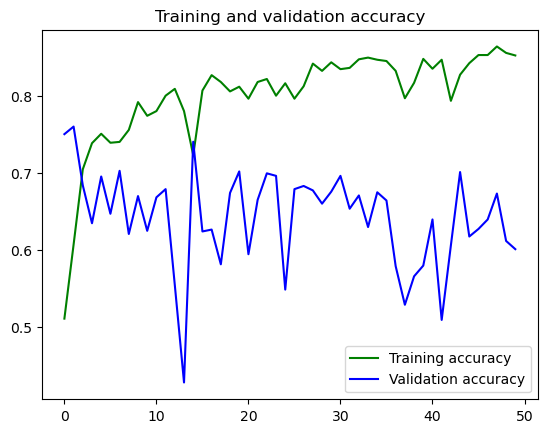

<Figure size 640x480 with 0 Axes>

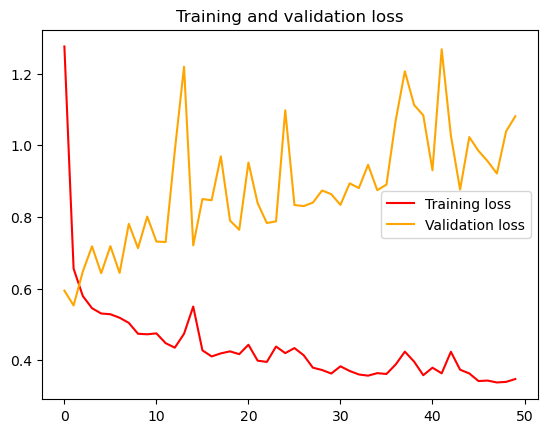

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.legend(loc=0)
plt.savefig("AccuracyResNet50_50.png")
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')

plt.legend(loc=0)
plt.savefig("LossResNet50_50.png")
plt.figure()
plt.show()